# <center><span style='background:yellow'> Détectez les Bad Buzz grâce au Deep Learning</span></center>
# <center><span style='background:yellow'>Exploration et nettoyage des données</span></center>
=========================================================================================================================

### Table of Contents <a class="anchor" id="sommaire"></a>
* [Contexte](#0)
* [Import et chargement des données](#1)
* [Exploration des données](#2)
* [Nettoyage et visualisation des tweets](#3)
    * [Nettoyage des tweets](#31)
    * [Visualisation des corpus](#32)


# Contexte<a class="anchor" id="0"></a>

Air Paradis a missionné notre entreprise MIC (Marketing Intelligence Consulting), une entreprise de conseil spécialisée sur les problématiques de marketing digital pour créer un produit IA afin d'anticiper les bad buzz sur les réseaux sociaux en particulier TWITTER. 

Le but de ce projet est de préparer un prototype d'un produit IA afin de <span style='color:darkblue '> **prédire le sentiment associé à un tweet**</span>

Air Paradis ne dispose pas d'assez des données donc on va utiliser les données Open Source.  

Pour réaliser ce projet on va commencer d'abord par charger les librairies et les données nécessaires puis on va faire un nettoyage du corpus des tweets avec la librairie <span style='color:darkblue '> **spacy**</span> ensuite, on va vectoriser les tweets selon différentes méthodes et finalement on va entraîner nos modèles selon un modèle sur mesure simple, deux modèles sur avancés et un modèle BERT.

# Import et chargement des données<a class="anchor" id="1"></a>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisations de corpus
from wordcloud import WordCloud

# Diviser les données
from sklearn.model_selection import train_test_split

# Calcul en parallele
from pandarallel import pandarallel

import warnings


pandarallel.initialize(progress_bar=True, 
                       nb_workers=6, 
                       verbose=2)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
path = ''

In [3]:
file = path + 'data/training.1600000.processed.noemoticon.csv'
data = pd.read_csv(file, encoding='latin-1', sep=',', header=None)

<a href="#sommaire" rev="footnote">&#8617;</a>

# Exploration des données<a class="anchor" id="2"></a>

On dispose d'un fichier .csv téléchargés depuis [ce lien](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip) contenant 1 600 000 tweets, leurs labels et d'autres informations comme l'identifiant et le nom d'utilisateur.  
On va commencer par faire une analyse exploratoire puis supprimer les doublons dans les tweets. 

In [4]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
print('Taille des données',data.shape)

Taille des données (1600000, 6)


In [6]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 556.1 MB


In [7]:
data.rename(columns={0 : 'label',
                     1 : 'user_id',
                     2 : 'date',
                     3 : 'query',
                     4 : 'user_name', 
                     5 : 'tweet'},
           inplace=True)

data.head()

,label,user_id,date,query,user_name,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
data['query'].value_counts()

NO_QUERY    1600000
Name: query, dtype: int64

In [9]:
data.drop(columns='query', inplace=True)

In [10]:
data[data.duplicated(subset=['user_id', 'user_name', 'tweet'], keep=False)].sort_values(by='user_id')

,label,user_id,date,user_name,tweet
213,0,1467863684,Mon Apr 06 22:33:35 PDT 2009,DjGundam,Awwh babs... you look so sad underneith that s...
800261,4,1467863684,Mon Apr 06 22:33:35 PDT 2009,DjGundam,Awwh babs... you look so sad underneith that s...
275,0,1467880442,Mon Apr 06 22:38:04 PDT 2009,iCalvin,Haven't tweeted nearly all day Posted my webs...
800300,4,1467880442,Mon Apr 06 22:38:04 PDT 2009,iCalvin,Haven't tweeted nearly all day Posted my webs...
989,0,1468053611,Mon Apr 06 23:28:09 PDT 2009,mariejamora,@hellobebe I also send some updates in plurk b...
...,...,...,...,...,...
524290,0,2193428118,Tue Jun 16 08:26:44 PDT 2009,bubbles00,"finally finished typing!!!! Woohoooo , still ..."
1599440,4,2193451289,Tue Jun 16 08:28:37 PDT 2009,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo..."
524345,0,2193451289,Tue Jun 16 08:28:37 PDT 2009,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo..."
524688,0,2193576442,Tue Jun 16 08:38:45 PDT 2009,emma_b_xox,Had an injection today. Not fun the rrst of t...


In [11]:
data.drop_duplicates(subset=['user_id', 'user_name', 'tweet'], keep='first', inplace=True)

In [12]:
data.shape

(1598315, 5)

In [13]:
data.head()

,label,user_id,date,user_name,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


**Distribution des labels**

La colonne label contient le label d'un tweet :    
  * 0 représente un tweet négatif  
  * 4 représente un tweet positif, on va remplacer 4 par 1

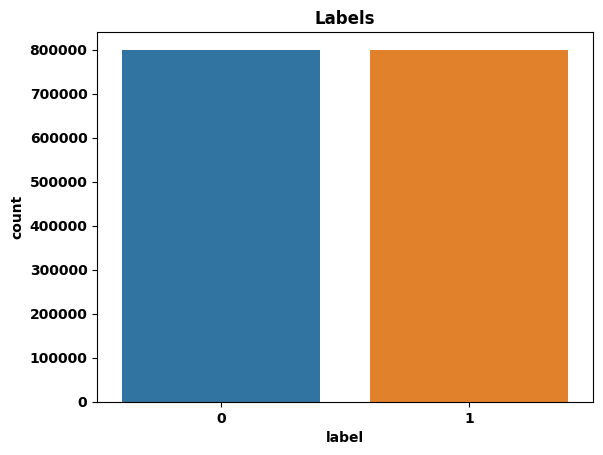

In [14]:
data.loc[data.label==4, 'label'] = 1
sns.countplot(data=data, x = "label")
plt.title('Labels')
plt.show()

<a href="#sommaire" rev="footnote">&#8617;</a>

# Nettoyage et visualisation des tweets<a class="anchor" id="3"></a>

Pour limiter le temps de calcul, on va faire l'analyse d'un un sous-échantillon de 1 000 000 de 1 600 000 tweets, puis on va diviser notre échantillon à 3 datasets :
  * Données d'apprentissage de 630 000 tweets pour entaîner nos modèles
  * Données de validation de 270 000 tweets pour calculer les scores et comparer entre les modèles
  * Données de test de 100 000 tweets pour réaliser un contrôl final
  
Puis on va nettoyer notre corpus selon deux méthodes:
  * Nettoyage avec lemmatisation
  * Nettoyage avec stemming

**Extraire un sous échantillon des tweets**

In [15]:
seed = 0
n_samples = 1_000_000
df = data[['tweet', 'label']].sample(n_samples)
df.shape
df.head()

,tweet,label
783487,So wanna go home and curl on my bed now,0
560689,The arm just fell of my computer chair Now wh...,0
190629,I saw my uncle today he doesn't look too good...,0
266561,chillin at mi casa with jessie...shes trying t...,0
527440,BlackBerry Messenger is down on my phone. I'm ...,0


**Split des données**

In [16]:
train_val, test = train_test_split(df, 
                                   test_size = 0.1,
                                   stratify = df.label,
                                   random_state = seed)
train, validation = train_test_split(train_val, 
                                     test_size = 0.3,
                                     stratify = train_val.label,
                                     random_state = seed)
train.shape, validation.shape, test.shape

((630000, 2), (270000, 2), (100000, 2))

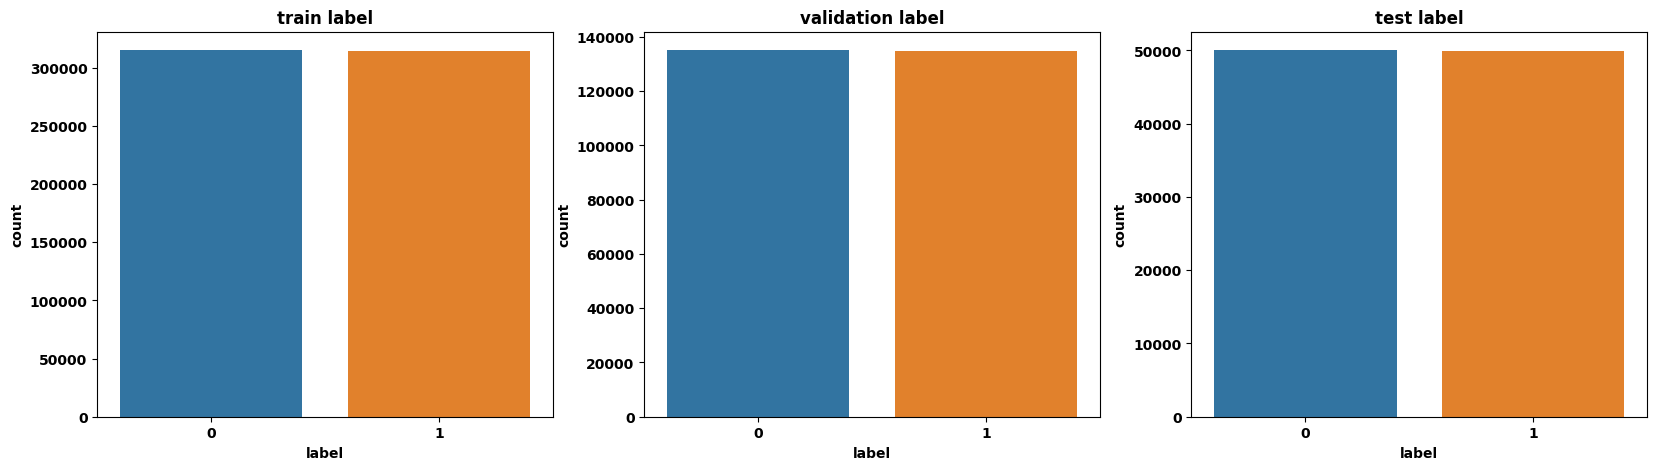

In [17]:
fig , ax = plt.subplots(1,3, figsize=(20,5))
title = 'train'
ax[0].set_title('train label')
sns.countplot(data = train, x = 'label', ax=ax[0])
title = 'validation'
ax[1].set_title('validation label')
sns.countplot(data = validation, x = 'label', ax=ax[1])
title = 'test'
ax[2].set_title('test label')
sns.countplot(data = test, x = 'label', ax=ax[2])
plt.show()

**Corpus train**

In [18]:
#Display tokens infos
def display_token_info(doc):
    """token infos
    """       
    print('Nombre total de tokens', len(doc),', nombre unique de tokens', len(set(doc)))        

In [19]:
# test de la fonction display_token_info
tweet = train.tweet.iloc[0]
print('Tweet :','\"'+tweet+'\"')
display_token_info(tweet.split())

Tweet : "#Goodsex When he makes you squirt all over him  "
Nombre total de tokens 9 , nombre unique de tokens 9


In [20]:
corpus_tweets = ' '.join(train.tweet)
display_token_info(corpus_tweets.split())

Nombre total de tokens 8294262 , nombre unique de tokens 686186


<a href="#sommaire" rev="footnote">&#8617;</a>

## Nettoyage des tweets<a class="anchor" id="31"></a>

**Fonctions de nettoyage**

In [21]:
#============================================================================================================================
                                               # Nettoyage avec lemmatization
#============================================================================================================================
def tweet_clean_lemm(text):
    """ Nettoyé et lemmatiser un texte
        
    Parametrs: 
                text (str) : texte à nettoyer et à lemmatiser
    Returns: 
                (str) : texte nettoyé et lemmatisé
                
    """
    import spacy
    import re
    from spacy.tokens import Token
    nlp = spacy.load('en_core_web_sm')
    nlp.Defaults.stop_words -= {'not', 'never'}
    
    # user_name regular expression
    regex_user = r"@[\w\d_]+"
    is_user = lambda token: re.fullmatch(regex_user, token.text)
    Token.set_extension("is_user", getter=is_user, force=True)

    doc = nlp(text)
    tokens = [token.lemma_ .lower()
              for token in doc 
              if (not token.is_punct)     # supprimer les ponctuations
              and (len(token)>1)          # supprimer les token de longueur 1
              and (not token.is_stop)     # supprimer les stopwords
              and (not token.is_space)    # supprimer les espaces vides
              and (not token.is_digit)    # supprimer les nombres
              and (not token.like_email)  # supprimer les emails
              and (not token.like_url)    # supprimer les URLs
              and (not token._.is_user)]  # supprimer les noms d'utilisateurs

    return ' '.join(tokens)



#============================================================================================================================
                                                 # Nettoyage avec stemming
#============================================================================================================================

def tweet_clean_stem(text):
    """ Nettoyer et stemmer un texte
        
    Parametrs: 
                text (str) : texte à nettoyer et stemmer
    Returns: 
                (str) : texte nettoyé et stemmé
                
    """
    import spacy
    from spacy.tokens import Token
    import re
    import nltk
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer(language='english')
    nlp = spacy.load('en_core_web_sm')
    nlp.Defaults.stop_words -= {'not', 'never'}
    
    # user_name regular expression
    regex_user = r"@[\w\d_]+"
    is_user = lambda token: re.fullmatch(regex_user, token.text)
    Token.set_extension("is_user", getter=is_user, force=True)

    doc = nlp(text)
    tokens = [stemmer.stem(token.lower_)
              for token in doc 
              if (not token.is_punct)     # supprimer les ponctuations
              and (len(token)>1)          # supprimer les token de longueur 1
              and (not token.is_stop)     # supprimer les stopwords
              and (not token.is_space)    # supprimer les espaces vides
              and (not token.is_digit)    # supprimer les nombres
              and (not token.like_email)  # supprimer les emails
              and (not token.like_url)    # supprimer les URLs
              and (not token._.is_user)]  # supprimer les noms d'utilisateurs

    return ' '.join(tokens)

In [22]:
# test de la fonction tweet_clean_lemm
i = 57
tweet = train.tweet.iloc[i]
print('Tweet         :','\"'+tweet+'\"')
print('Tweet cleaned :','\"'+ tweet_clean_lemm(tweet)+'\"')

Tweet         : "@rumoko Yeahh I guess, I was just so INSIDE this world that it was abrupt to have it just end like that. I want more "
Tweet cleaned : "yeahh guess inside world abrupt end like want"


In [23]:
# test de la fonction tweet_clean_stem
tweet = train.tweet.iloc[i]
print('Tweet         :','\"'+tweet+'\"')
print('Tweet cleaned :','\"'+ tweet_clean_stem(tweet)+'\"')

Tweet         : "@rumoko Yeahh I guess, I was just so INSIDE this world that it was abrupt to have it just end like that. I want more "
Tweet cleaned : "yeahh guess insid world abrupt end like want"


In [24]:
train.head()

,tweet,label
1273151,#Goodsex When he makes you squirt all over him,1
445145,Looking for a &quot;Sexy Sailors&quot; outfit ...,0
499993,i dont know why twitter just now sent that thr...,0
122529,A particularly brutal rejection has put me off...,0
1322335,@bets_carabuena dear! sa friday pa dito thurs...,1


In [25]:
train.head()

,tweet,label
1273151,#Goodsex When he makes you squirt all over him,1
445145,Looking for a &quot;Sexy Sailors&quot; outfit ...,0
499993,i dont know why twitter just now sent that thr...,0
122529,A particularly brutal rejection has put me off...,0
1322335,@bets_carabuena dear! sa friday pa dito thurs...,1


**Lemmatiser le corpus d'entraînement**

In [26]:
%%time
train['tweet_clean_lemm'] = train['tweet'].parallel_apply(tweet_clean_lemm)

Wall time: 1d 14h 5min 42s


**Stemmer le corpus d'entraînement**

In [28]:
%%time
train['tweet_clean_stem'] = train['tweet'].parallel_apply(tweet_clean_stem)

Wall time: 1d 16h 59min 59s


In [43]:
train.to_csv(path + 'data/train.csv')

**Lemmatiser le corpus de validation**

In [29]:
train.head()

,tweet,label,tweet_clean_lemm,tweet_clean_stem
1273151,#Goodsex When he makes you squirt all over him,1,goodsex make squirt,goodsex make squirt
445145,Looking for a &quot;Sexy Sailors&quot; outfit ...,0,look quot;sexy sailors&quot outfit laura hen n...,look quot;sexi sailors&quot outfit laura hen n...
499993,i dont know why twitter just now sent that thr...,0,not know twitter send word headache,nt know twitter sent word headach
122529,A particularly brutal rejection has put me off...,0,particularly brutal rejection writing never co...,particular brutal reject write never consid eg...
1322335,@bets_carabuena dear! sa friday pa dito thurs...,1,dear sa friday pa dito thursday ang game,dear sa friday pa dito thursday ang game


In [30]:
%%time
validation['tweet_clean_lemm'] = validation['tweet'].parallel_apply(tweet_clean_lemm)

Wall time: 15h 35min 57s


In [31]:
validation.head()

,tweet,label,tweet_clean_lemm
1040898,Is tired at a good time of the night! That's a...,1,tired good time night good thing
797730,Kinda bummed that all the stuff I've worked on...,0,kinda bum stuff work past week turn ie bug
137490,Interest payment on savings account. More mone...,0,interest payment saving account money half int...
781804,i cant sleep!! and i want chinese food fries.....,0,not sleep want chinese food fry im hungry
491724,Bored n the House so Sick of the Rain ! uGh..,0,bored house sick rain ugh


**Stemmer le corpus de validation**

In [32]:
%%time
validation['tweet_clean_stem'] = validation['tweet'].parallel_apply(tweet_clean_stem)

Wall time: 17h 53min 7s


In [33]:
validation.head()
validation.to_csv(path + 'data/validation.csv')

**Lemmatiser le corpus de test**

In [34]:
%%time
test['tweet_clean_lemm'] = test['tweet'].parallel_apply(tweet_clean_lemm)

Wall time: 6h 27min 15s


In [35]:
test.head()

,tweet,label,tweet_clean_lemm
490007,Is really hurt.,0,hurt
1347780,I just bought Six Flags tickets online!! Pavel...,1,buy flags ticket online pavel go tomorrow sooo...
1476645,@ladymaryann watched it!,1,watch
181699,i spilled water all over the seat and myself,0,spill water seat
1065563,I'm getting ready to go get some food!! The k...,1,get ready food kid hungry


**Stemmer le corpus de test**

In [36]:
%%time
test['tweet_clean_stem'] = test['tweet'].parallel_apply(tweet_clean_stem)

Wall time: 6h 20min 11s


In [37]:
test.head()
test.to_csv(path + 'data/test.csv')

<a href="#sommaire" rev="footnote">&#8617;</a>

## Visualisation du corpus<a class="anchor" id="32"></a>

In [38]:
display_token_info(corpus_tweets.split())

Nombre total de tokens 8294262 , nombre unique de tokens 686186


In [39]:
corpus_tweets_lemm = ' '.join(train['tweet_clean_lemm'])
display_token_info(corpus_tweets_lemm.split())

Nombre total de tokens 3896334 , nombre unique de tokens 181016


In [40]:
corpus_tweets_stem = ' '.join(train['tweet_clean_stem'])
display_token_info(corpus_tweets_stem.split())

Nombre total de tokens 3896334 , nombre unique de tokens 162473


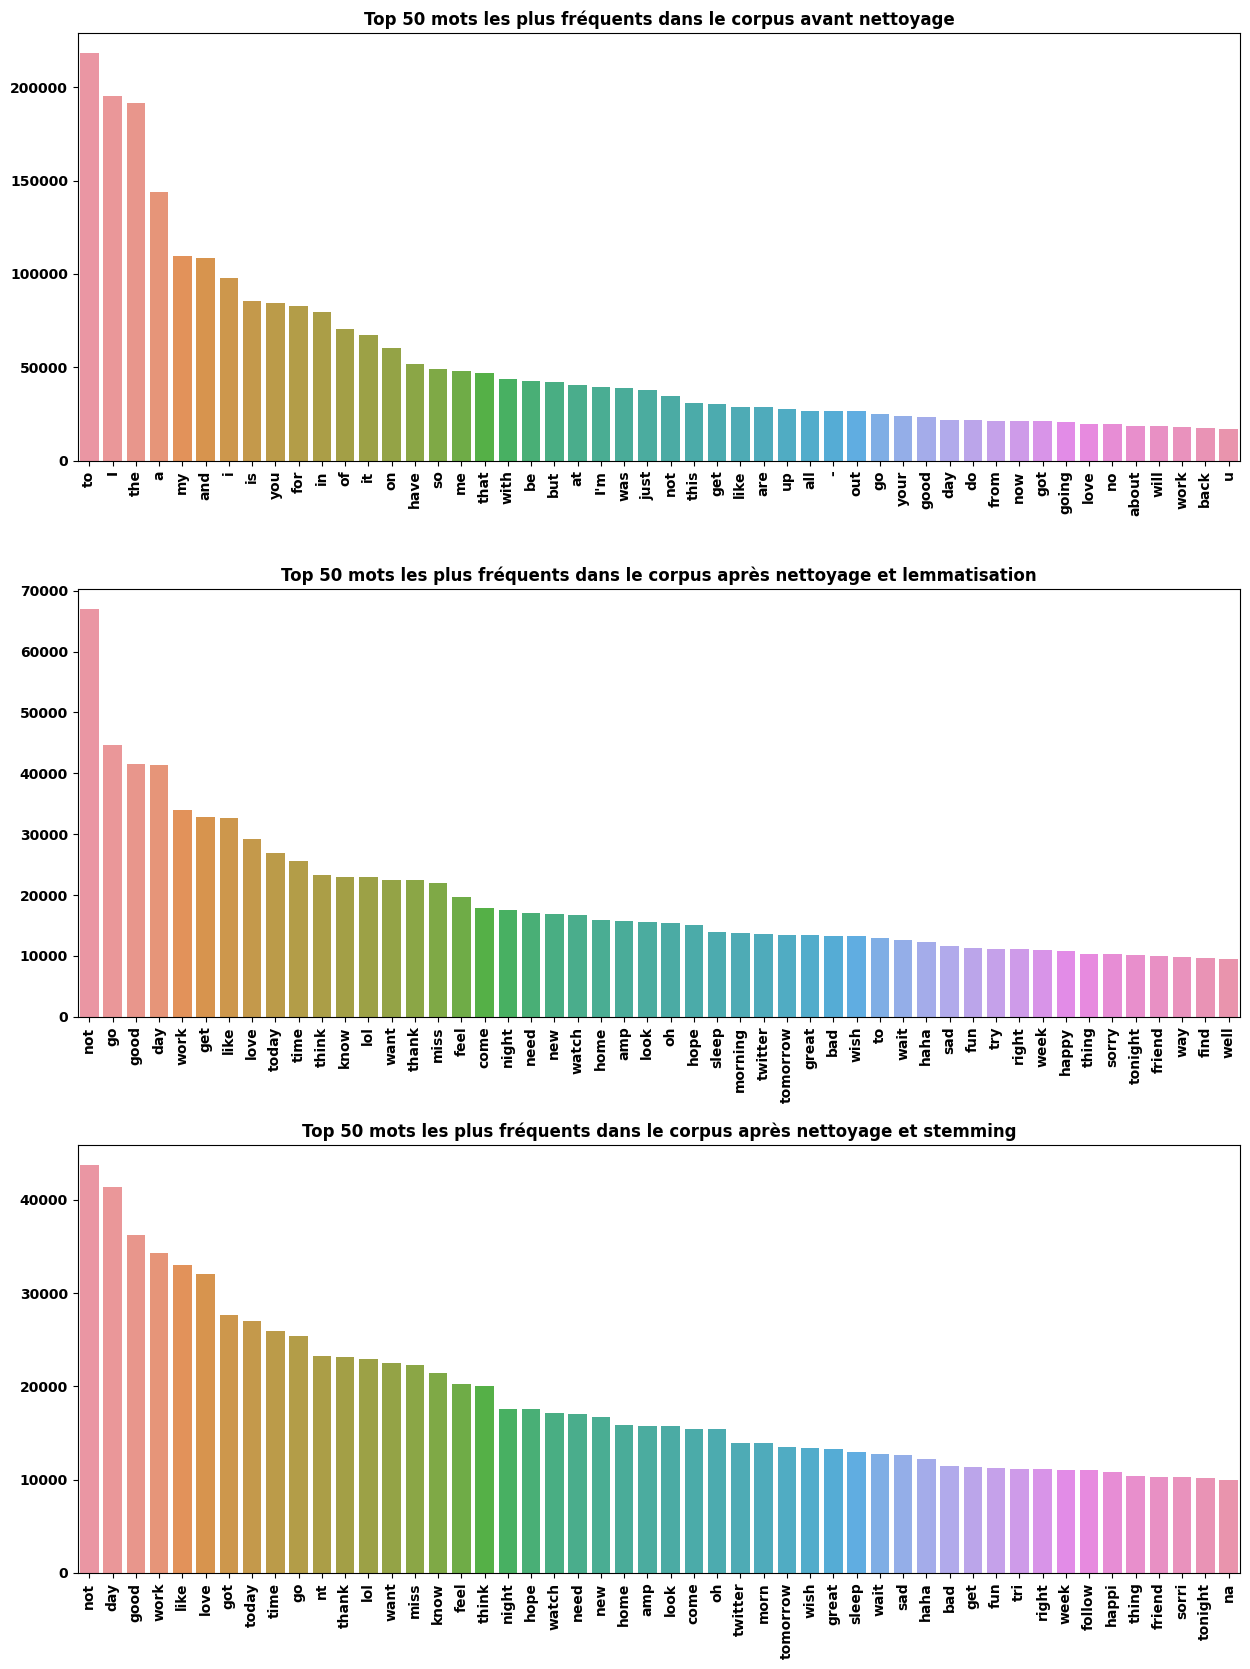

In [41]:
import warnings
warnings.filterwarnings('ignore')

fig1 = plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
corpus_serie = pd.Series(corpus_tweets.split()).value_counts()[0:50]
sns.barplot(x = corpus_serie.index,
            y =  corpus_serie)
plt.xticks(rotation=90)
plt.title('Top 50 mots les plus fréquents dans le corpus avant nettoyage')

plt.subplot(312)
corpus_tweets_lemmm_serie = pd.Series(corpus_tweets_lemm.split()).value_counts()[0:50]
sns.barplot(x = corpus_tweets_lemmm_serie.index,
            y = corpus_tweets_lemmm_serie)
plt.xticks(rotation=90)
plt.title('Top 50 mots les plus fréquents dans le corpus après nettoyage et lemmatisation')


plt.subplot(313)
corpus_tweets_stem_serie = pd.Series(corpus_tweets_stem.split()).value_counts()[0:50]
sns.barplot(x = corpus_tweets_stem_serie.index,
            y = corpus_tweets_stem_serie)
plt.xticks(rotation=90)
plt.title('Top 50 mots les plus fréquents dans le corpus après nettoyage et stemming' )

plt.show()
# fig.savefig('cleantext.png')

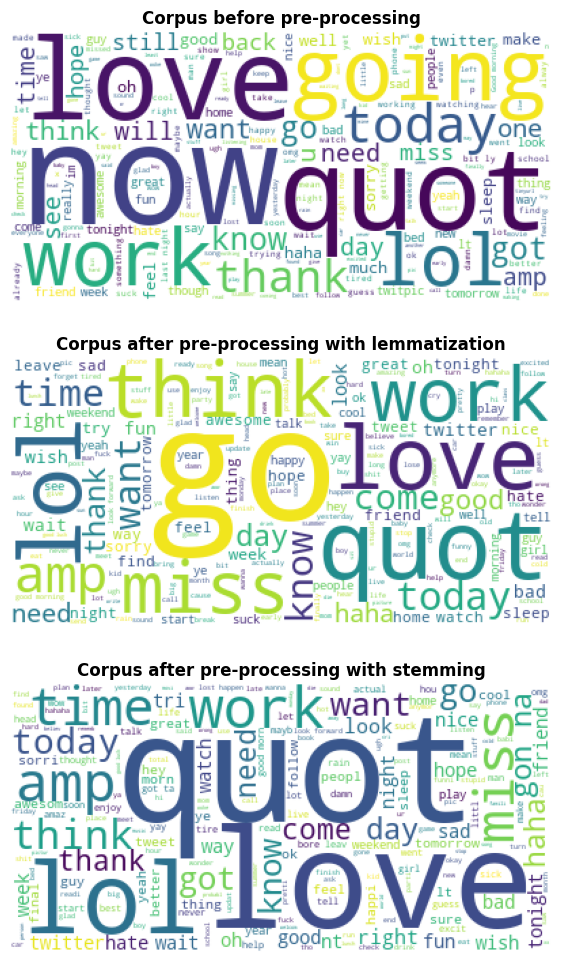

In [42]:
fig2 = plt.figure(figsize=(7,12))

plt.subplot(311)
word_cloud = WordCloud(background_color='white').generate(corpus_tweets)
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Corpus before pre-processing')

plt.subplot(312)
word_cloud = WordCloud(background_color='white').generate(corpus_tweets_lemm)
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Corpus after pre-processing with lemmatization')

plt.subplot(313)
word_cloud = WordCloud(background_color='white').generate(corpus_tweets_stem)
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Corpus after pre-processing with stemming' )
plt.show()

<a href="#sommaire" rev="footnote">&#8617;</a>